In [1]:
# Copyright 2020 Erik Härkönen. All rights reserved.
# This file is licensed to you under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License. You may obtain a copy
# of the License at http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software distributed under
# the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR REPRESENTATIONS
# OF ANY KIND, either express or implied. See the License for the specific language
# governing permissions and limitations under the License.
%matplotlib inline
import time
from notebook_init import *

out_root = Path('out/iter')
makedirs(out_root, exist_ok=True)
rand = lambda : np.random.randint(np.iinfo(np.int32).max)
torch.autograd.set_grad_enabled(True)

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


In [2]:
use_w = True
dataset = 'ffhq'
inst = get_instrumented_model('StyleGAN2', dataset, 'style', device, inst=inst, use_w=use_w)
model = inst.model
model.truncation = 1.0

Loading ../models/checkpoints/stylegan2/stylegan2_ffhq_1024.pt


366745668
Getting iter trvs took 0.33063817024230957
Getting iter trvs took 0.3377084732055664
Getting iter trvs took 0.34848666191101074
Getting iter trvs took 0.31601667404174805
Getting iter trvs took 0.3128023147583008


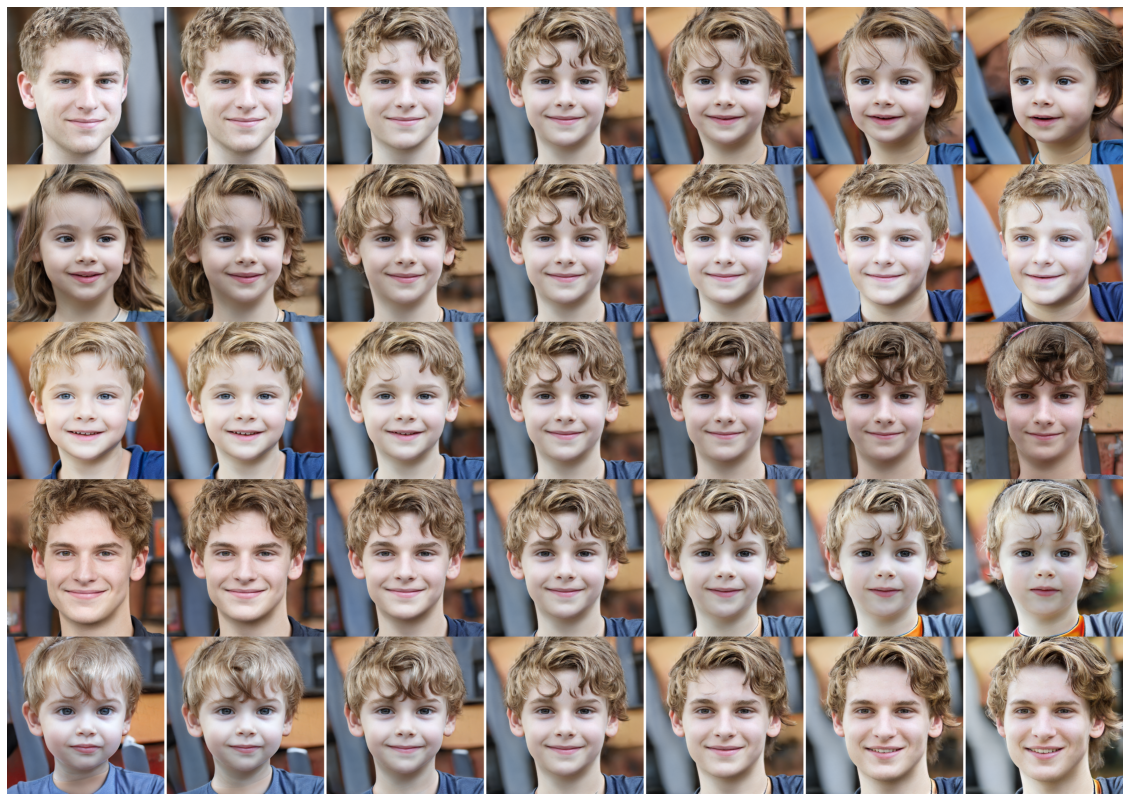

In [3]:
seeds_ffhq = [366745668,] #327039870] #, 1502970553, 1235907362, 1302626592]
# seeds_ffhq = [1257084100]
# seeds_ffhq = [366745668, 1502970553, 1235907362, 1302626592]
# seeds_ffhq = [rand() for _ in range(50)]
start_direction = 0
n_direction = 5
save_img = False
num_frames = 7
num_steps = 3
layer_mode = 'all'
perturb_intensity = 5

data_path = out_root / dataset
makedirs(data_path, exist_ok=True)
for seed in seeds_ffhq:
    print(seed)
    rng = np.random.RandomState(seed)
    noise, z, z_local_basis, z_sv, noise_basis = get_random_local_basis(model, rng)
    layer_start, layer_end = LayerMode(layer_mode)
    strips = []
    with torch.no_grad():
        for trvs_idx in range(start_direction, start_direction+n_direction):
            #batch_frames = create_strip(inst, 'latent', 'style', [z], 0, orient * local_lat_comp[i], 0, local_lat_std[i], perturb_intensity, 0, 18, num_frames=7)[0]
            batch_frames, z_batch = create_strip_iter(inst, 'latent', 'style', trvs_idx, sigma = perturb_intensity, layer_start = layer_start, layer_end = layer_end, 
                                             random_state = None, noise = noise, compare_basis = True, num_frames=num_frames, num_steps = num_steps*2, only_pos=0, scale = 1, verbose=0)
            strips.append(np.hstack(pad_frames(batch_frames[0])))
    grid = np.vstack(strips)

    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(data_path / f'iter_local_grid_{seed}_{start_direction}to{start_direction+n_direction-1}_ptb{perturb_intensity}_{layer_mode}.jpg') 
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()